## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [3]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import get_file, plot_model


In [ ]:
sns.set(style='white')
plt.style.use('seaborn-white')


### 데이터 로드

In [7]:
dataset_path = get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\USER\\.keras\\datasets\\auto-mpg.data'

In [9]:
column_names =['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

### 데이터 확인

In [10]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리


- 해당 데이터는 일부 데이터가 누락되어 있음

In [26]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 24.5 KB


In [27]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [28]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [29]:
dataset = dataset.dropna()

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [30]:
dataset['Origin'].unique()  # 엔진 만드는 origin 회사

array([1, 3, 2], dtype=int64)

In [31]:
origin = dataset.pop('Origin') # pop() : dataset['Origin']을 꺼내서 origin에 저장하고 삭제한다. 

In [32]:
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0

In [33]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


#### 검증 데이터셋 생성

In [34]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### 데이터 조사

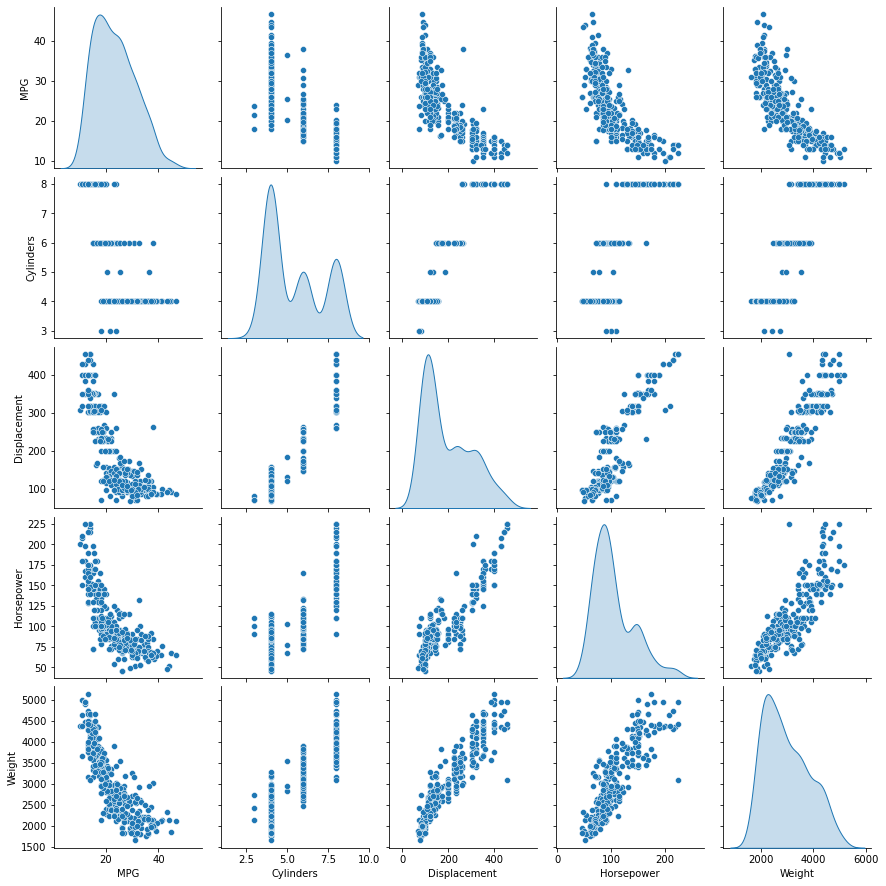

In [37]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight']], diag_kind='kde')

In [39]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 데이터의 특성과 레이블 분리

In [40]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### 데이터 정규화

In [41]:
def normalization(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalization(train_dataset)
normed_test_data = normalization(test_dataset)

### 모델 구성

In [44]:
def build_model():
    input = Input(shape=(len(train_dataset.keys())), name='input')
    hidden1 = Dense(64, activation='relu', name='dense1')(input)
    hidden2 = Dense(64, activation='relu', name='dense2')(hidden1)
    output = Dense(1, name='output')(hidden2)
    
    model = Model(inputs=[input], outputs=[output])
    
    model.compile(loss='mse',
                  optimizer=RMSprop(0.001),
                  metrics=['mae', 'mse'])
    return model

In [45]:
 model = build_model()

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9)]               0         
                                                                 
 dense1 (Dense)              (None, 64)                640       
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [47]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 샘플 데이터 확인

In [48]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

1/1 [==============================] - 0s 198ms/step


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


### 모델 학습

In [50]:
epochs = 1000

history = model.fit(normed_train_data, train_labels,
                    epochs=epochs, validation_split=0.2)

Epoch 1/1000
8/8 [==============================] - 1s 24ms/step - loss: 569.2435 - mae: 22.6156 - mse: 569.2435 - val_loss: 561.3900 - val_mae: 22.4122 - val_mse: 561.3900
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 517.8205 - mae: 21.4876 - mse: 517.8205 - val_loss: 509.2941 - val_mae: 21.2572 - val_mse: 509.2941
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 468.7480 - mae: 20.3613 - mse: 468.7480 - val_loss: 455.0021 - val_mae: 19.9913 - val_mse: 455.0021
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 416.7141 - mae: 19.1042 - mse: 416.7141 - val_loss: 396.2014 - val_mae: 18.5420 - val_mse: 396.2014
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 360.7061 - mae: 17.6724 - mse: 360.7061 - val_loss: 333.9610 - val_mae: 16.8751 - val_mse: 333.9610
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 303.1116 - mae: 16.0530 - mse: 303.1116 - val_loss: 272.8370 - val_

### 모델 학습 시각화

In [51]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [52]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,569.243469,22.615620,569.243469,561.390015,22.412163,561.390015,0
1,517.820496,21.487555,517.820496,509.294128,21.257181,509.294128,1
2,468.747955,20.361292,468.747955,455.002106,19.991320,455.002106,2
3,416.714050,19.104242,416.714050,396.201385,18.542038,396.201385,3
4,360.706146,17.672411,360.706146,333.960999,16.875145,333.960999,4
...,...,...,...,...,...,...,...
995,2.324959,0.952290,2.324959,8.891070,2.328320,8.891070,995
996,2.304204,0.949917,2.304204,8.829128,2.271521,8.829128,996
997,2.210091,0.952601,2.210091,8.453602,2.239056,8.453602,997
998,2.328631,0.965463,2.328631,8.774852,2.321434,8.774852,998


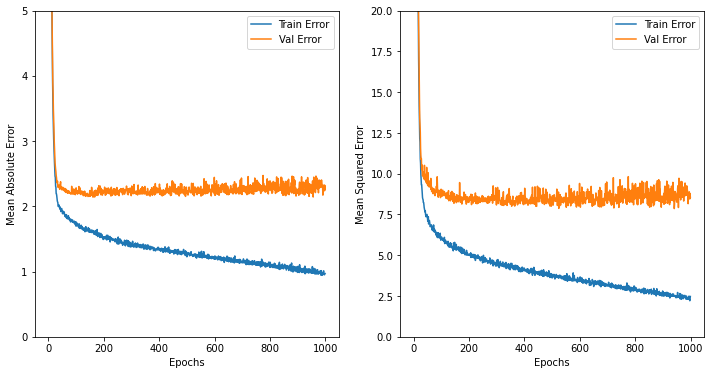

In [53]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0, 20])
    plt.legend()    
    
    plt.show()

plot_history(history)    

### EarlyStopping을 이용한 규제화

In [55]:
from tensorflow.keras.callbacks import EarlyStopping 

In [57]:
model = build_model()

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split=0.2, callbacks=[early_stop])

Epoch 1/1000
8/8 [==============================] - 1s 20ms/step - loss: 588.1158 - mae: 22.9362 - mse: 588.1158 - val_loss: 583.8388 - val_mae: 22.7692 - val_mse: 583.8388
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 541.2688 - mae: 21.8567 - mse: 541.2688 - val_loss: 538.8514 - val_mae: 21.7163 - val_mse: 538.8514
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 498.6232 - mae: 20.8098 - mse: 498.6232 - val_loss: 490.9958 - val_mae: 20.5313 - val_mse: 490.9958
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 452.3788 - mae: 19.6242 - mse: 452.3788 - val_loss: 437.7342 - val_mae: 19.1542 - val_mse: 437.7342
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 401.6471 - mae: 18.2796 - mse: 401.6471 - val_loss: 381.1053 - val_mae: 17.5810 - val_mse: 381.1053
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 347.7879 - mae: 16.7209 - mse: 347.7879 - val_loss: 320.7701 - val_

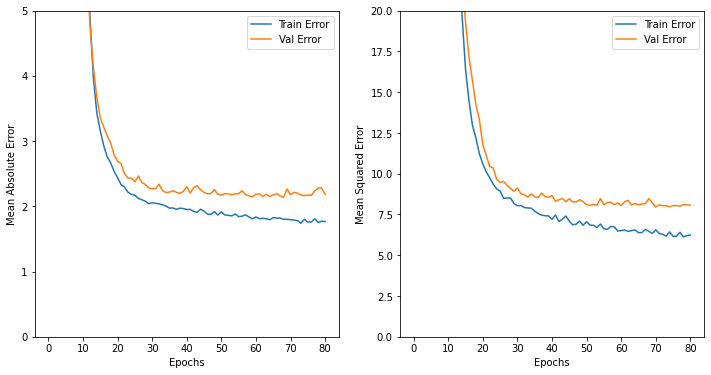

In [58]:
plot_history(history)

### 모델 평가

In [59]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print(mae)

3/3 - 0s - loss: 5.5268 - mae: 1.8141 - mse: 5.5268 - 19ms/epoch - 6ms/step
1.8140887022018433


### 학습된 모델을 통한 예측

3/3 [==============================] - 0s 999us/step


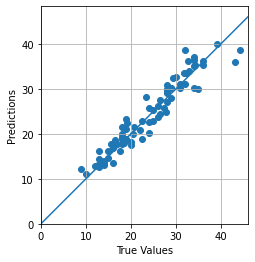

In [64]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])

plt.plot([-100, 100],[-100,100])

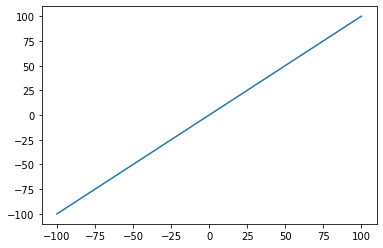

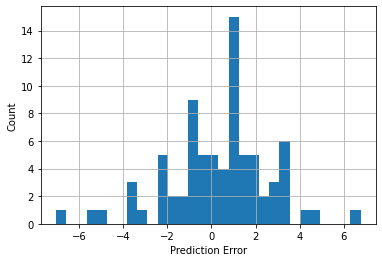

In [65]:
error = test_pred - test_labels
plt.hist(error, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.grid()